# Задача
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-07-14 по 2023-07-20. Задача аналитика – оценить эффективность этого мероприятия.

1. Предположить, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложить не менее 5 метрик.
2. Проверить, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - описать, как именно изменилась метрика и насколько.
3.Необязательно: имел ли флэшмоб какие-то долгосрочные эффекты?

## 1. Метрики которые могли изменится:
1. Количество лайков: количество лйков отображают воввлеченность аудитории .
2. Общее количество лайков: Общее количество лайков под постами с хэштегом #флэшмоб отражает общий интерес и вовлеченность пользователей в мероприятие.
3. DAU: отражает количество уникальных пользователей, которые активно взаимодействовали с продуктом или платформой в течение одного дня. В контексте флэшмоба, DAU покажет, сколько пользователей участвовало или реагировало на флэшмоб ежедневно в течение его продолжительности. Повышение DAU говорит о том, что флэшмоб привлек больше пользователей и сделал продукт более активным.
4. CTR: отражает процент пользователей, которые кликнули по ссылке или хэштегу, относительно общего числа пользователей, которые видели эту ссылку или хэштег. В контексте флэшмоба, CTR покажет, насколько успешно хэштег привлекал пользователей и стимулировал их участие. Повышение CTR говорит о том, что флэшмоб был привлекателен и вызывал интерес у аудитории.
5. Число событий на пользователя - так как растет число просмотров и число лайков, значит и число событий на пользователя должно увеличиваться.
   


In [ ]:
!pip install pandahouse

In [ ]:
!pip install tfcausalimpact

In [ ]:
import pandahouse as ph
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import causalimpact
from causalimpact import CausalImpact
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student',
                      'password':'dpo_python_2020'
                     }

# Количество лайков

In [ ]:
q_1 = """
SELECT toStartOfDay(time) AS day,
    countIf(action='like') AS likes
FROM {db}.feed_actions
GROUP BY day
ORDER BY day
"""

df_likes = ph.read_clickhouse(query=q_1, connection=connection)
df_likes = df_likes.set_index('day')
df_likes.head()

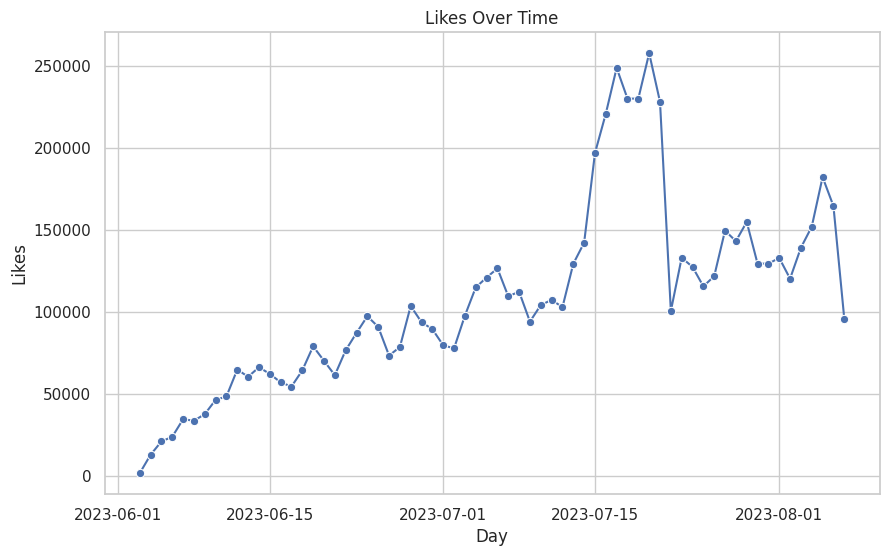

In [52]:
#Для оценки долгосрочности эффекта, построим графики
sns.set(style="whitegrid")  # Устанавливаем стиль сетки для графика
plt.figure(figsize=(10, 6))  # Увеличиваем размер графика
sns.lineplot(x='day', y='likes', data=df_likes, marker='o')
plt.xlabel('Day')
plt.ylabel('Likes')
plt.title('Likes Over Time')
plt.show()

In [ ]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact = CausalImpact(data=df_likes,
                      pre_period=['2023-06-03', '2023-07-13'],
                      post_period=['2023-07-14', '2023-07-20'])

In [ ]:
impact.plot()

In [ ]:
print(impact.summary())

In [ ]:
print(impact.summary('report'))

**Вывод**

В относительных значениях, зависимая переменная показала увеличение +188.21%.

Это означает, что положительный эффект, наблюдаемый в период вмешательства, имеет статистическую значимость.

Вероятность получения такого эффекта случайно очень мала (байесовская односторонняя вероятность области p = 0.0). Это означает, что причинный эффект можно считать статистически значимым, рост лайков вызван флешмобом

# Просмотры

In [ ]:
q_2 = """
SELECT
    toStartOfDay(time) day,
    countIf(action = 'view') views
FROM {db}.feed_actions
GROUP BY day
ORDER BY day
"""

df_views = ph.read_clickhouse(query=q_2, connection=connection)
df_views = df_views.set_index('day')
df_views.head()

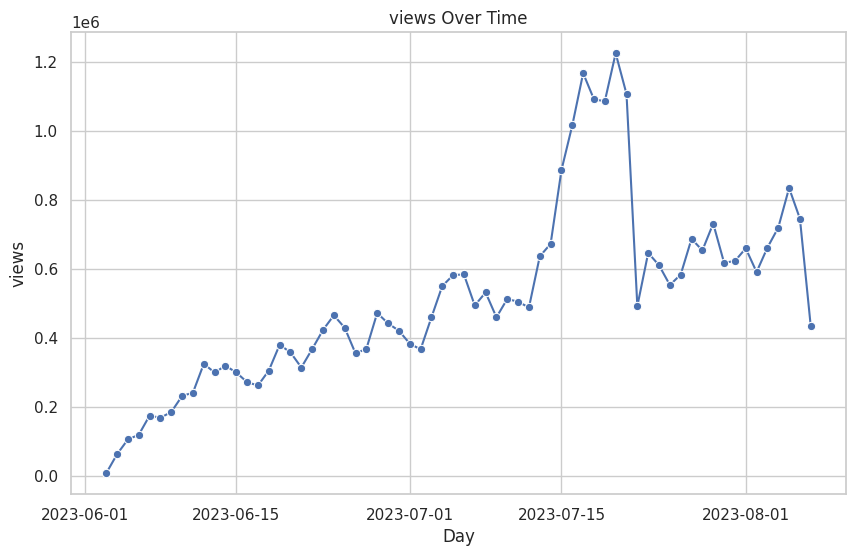

In [53]:
sns.set(style="whitegrid")  # Устанавливаем стиль сетки для графика
plt.figure(figsize=(10, 6))  # Увеличиваем размер графика
sns.lineplot(x='day', y='views', data=df_views, marker='o')
plt.xlabel('Day')
plt.ylabel('views')
plt.title('views Over Time')
plt.show()

In [ ]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact_2 = CausalImpact(data=df_views,
                      pre_period=['2023-06-03', '2023-07-13'],
                      post_period=['2023-07-14', '2023-07-20'])

In [ ]:
impact_2.plot()

In [ ]:
print(impact_2.summary())

In [ ]:
print(impact_2.summary('report'))

С просмотрами ситуация аналогична лайкам. Наблюдается сильный рост числа просмотров: на 656795 в абсолютных значениях и на 180% в относительных. Данное увеличение является статистически значимым. Вероятность того, что этот эффект произошел случайно равна 0. Значит этот рост вызван, проведенным флешмобом.

# DAU

In [31]:
q_3 = """
SELECT toStartOfDay(time) AS day,
       count(DISTINCT user_id) AS dau
FROM {db}.feed_actions
GROUP BY day
ORDER BY day
"""

df_dau = ph.read_clickhouse(query=q_3, connection=connection)
df_dau = df_dau.set_index('day')
df_dau.head()

,dau
day,
2023-06-03,878
2023-06-04,2238
2023-06-05,3105
2023-06-06,3721
2023-06-07,4617


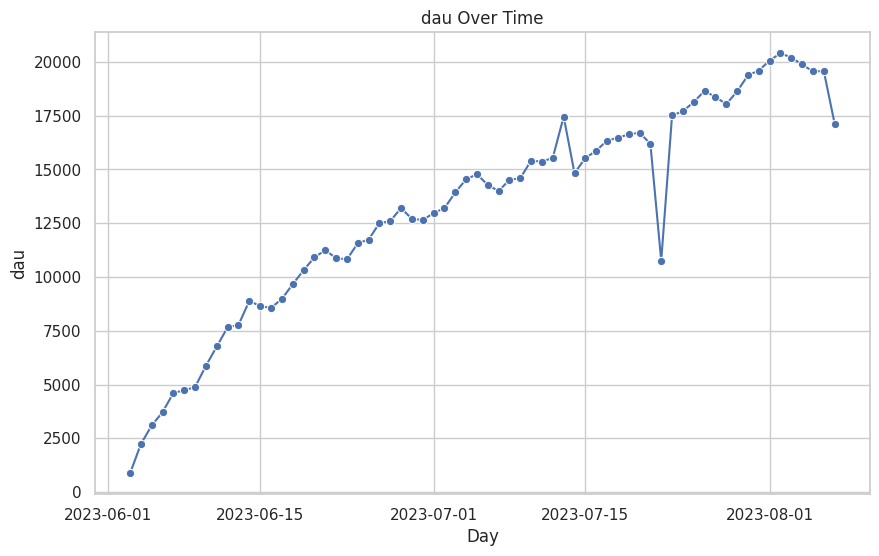

In [54]:
sns.set(style="whitegrid")  # Устанавливаем стиль сетки для графика
plt.figure(figsize=(10, 6))  # Увеличиваем размер графика
sns.lineplot(x='day', y='dau', data=df_dau, marker='o')
plt.xlabel('Day')
plt.ylabel('dau')
plt.title('dau Over Time')
plt.show()

In [34]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact_3 = CausalImpact(data=df_dau,
                      pre_period=['2023-06-03', '2023-07-13'],
                      post_period=['2023-07-14', '2023-07-20'])

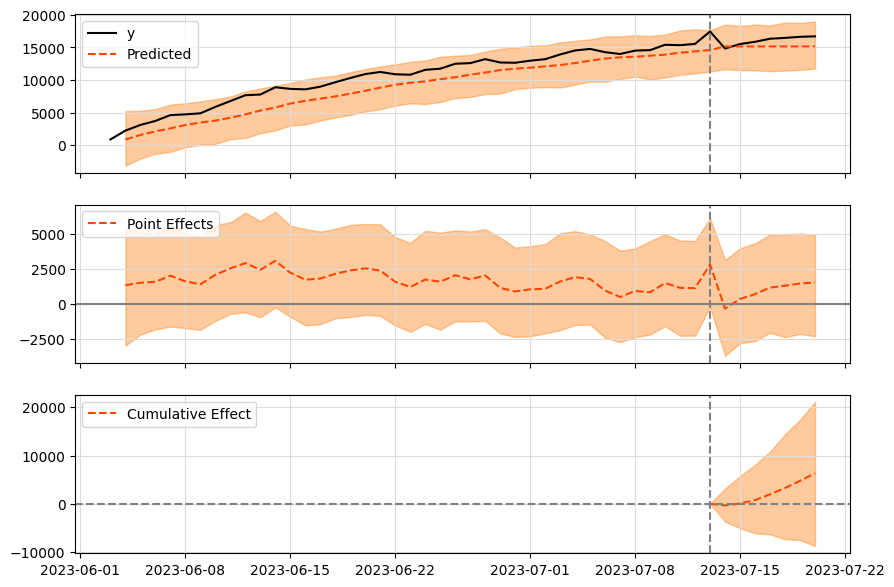

In [35]:
impact_3.plot()

In [36]:
print(impact_3.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         15151.24 (1034.13) 106058.7 (7238.93)
95% CI                    [13033.32, 17087.05][91233.25, 119609.36]

Absolute effect (s.d.)    901.47 (1034.13)   6310.3 (7238.93)
95% CI                    [-1034.34, 3019.39][-7240.36, 21135.75]

Relative effect (s.d.)    5.95% (6.83%)      5.95% (6.83%)
95% CI                    [-6.83%, 19.93%]   [-6.83%, 19.93%]

Posterior tail-area probability p: 0.19
Posterior prob. of a causal effect: 81.42%

For more details run the command: print(impact.summary('report'))


In [ ]:
print(impact_3.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. In the absence of an
intervention, we would have expected an average response of 14990.1.
The 95% interval of this counterfactual prediction is [12712.04, 17107.8].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1062.61 with a 95% interval of
[-1055.09, 3340.67]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
Had the intervention not taken place, we would have expected
a sum of 104930.73. The 95% interval of this prediction is [88984.31, 119754.6].


The above results are given in terms of absolute numbers. In relative
terms, the response variab

Исследуемая метрика показала рост на +7,09%.

Флешмоб дало положительный эффект, но этот эффект не является статистически значимым при рассмотрении всего периода после вмешательства в целом. Видимый эффект может быть результатом случайных колебаний, не связанных с вмешательством.

Эффект может быть ложным и не считается статистически значимым.Пока рано делать выводы

## CTR

In [37]:
# Извлекаем данные по CTR и преобразуем таблицу
q_4 = '''
SELECT
    toStartOfDay(time) day,
    countIf(action = 'like')/countIf(action = 'view') CTR
FROM {db}.feed_actions
GROUP BY day
ORDER BY day
'''

df_ctr = ph.read_clickhouse(query=q_4, connection=connection)
df_ctr = df_ctr.set_index('day')
df_ctr.head()

,CTR
day,
2023-06-03,0.205182
2023-06-04,0.204174
2023-06-05,0.198605
2023-06-06,0.200007
2023-06-07,0.197783


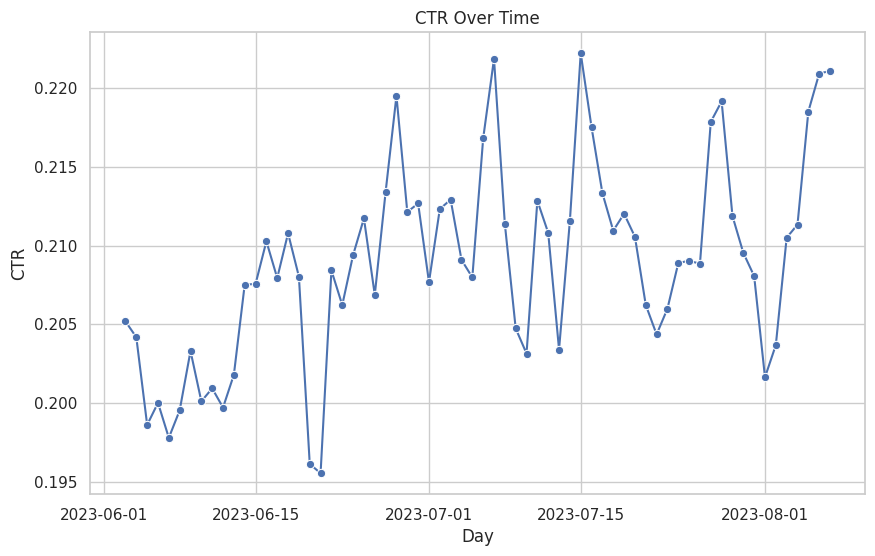

In [55]:
sns.set(style="whitegrid")  # Устанавливаем стиль сетки для графика
plt.figure(figsize=(10, 6))  # Увеличиваем размер графика
sns.lineplot(x='day', y='CTR', data=df_ctr, marker='o')
plt.xlabel('Day')
plt.ylabel('CTR')
plt.title('CTR Over Time')
plt.show()

In [39]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact_4 = CausalImpact(data=df_ctr,
                      pre_period=['2023-06-03', '2023-07-13'],
                      post_period=['2023-07-14', '2023-07-20'])

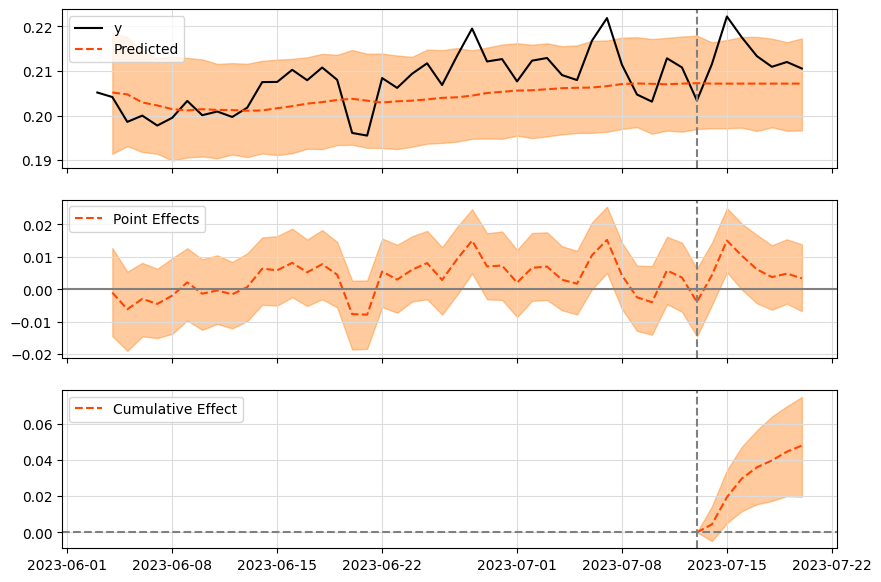

In [40]:
# Визуализауция результата
impact_4.plot()

In [41]:
print(impact_4.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.02)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.02)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.3% (1.05%)       3.3% (1.05%)
95% CI                    [1.23%, 5.36%]     [1.23%, 5.36%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [42]:
print(impact_4.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. By contrast, in the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.2, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 1.45. The 95% interval of this prediction is [1.42, 1.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incre

Существует незначительное увеличение CTR: на 0.01 в абсолютных значениях и на 3.3% в относительных. Хотя рост небольшой, но данное увеличение является статистически значимым. Вероятность того, что этот эффект произошел случайно равна 0. Значит этот рост вызван, проведенным флешмобом.

# Число событий на пользователя

In [43]:
q_5 = """
SELECT toStartOfDay(time) day,
       COUNT(action) / count(distinct user_id) AS actions
FROM {db}.feed_actions
GROUP BY day
ORDER BY day
"""

df_actions = ph.read_clickhouse(query=q_5, connection=connection)
df_actions = df_actions.set_index('day')
df_actions.head()

,actions
day,
2023-06-03,10.436219
2023-06-04,33.773905
2023-06-05,40.735588
2023-06-06,38.375705
2023-06-07,45.258393


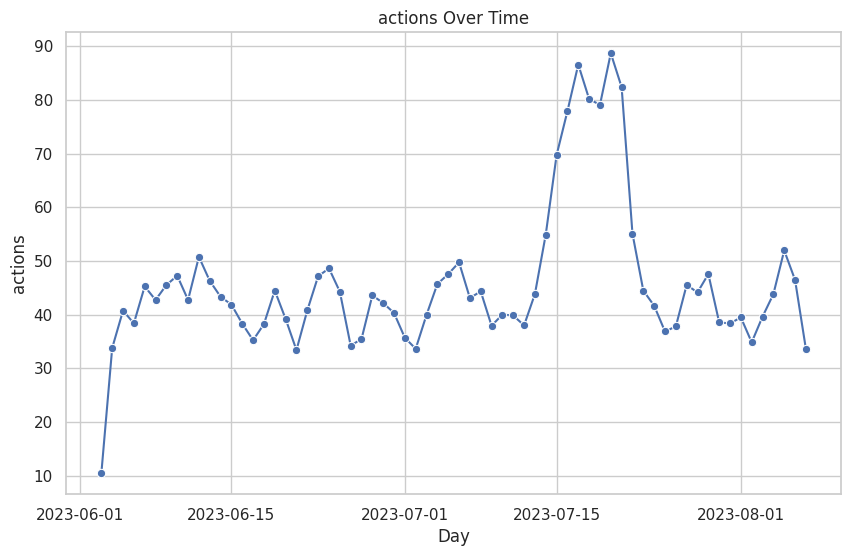

In [56]:
sns.set(style="whitegrid")  # Устанавливаем стиль сетки для графика
plt.figure(figsize=(10, 6))  # Увеличиваем размер графика
sns.lineplot(x='day', y='actions', data=df_actions, marker='o')
plt.xlabel('Day')
plt.ylabel('actions')
plt.title('actions Over Time')
plt.show()

In [45]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact_5 = CausalImpact(data=df_actions,
                      pre_period=['2023-06-03', '2023-07-13'],
                      post_period=['2023-07-14', '2023-07-20'])

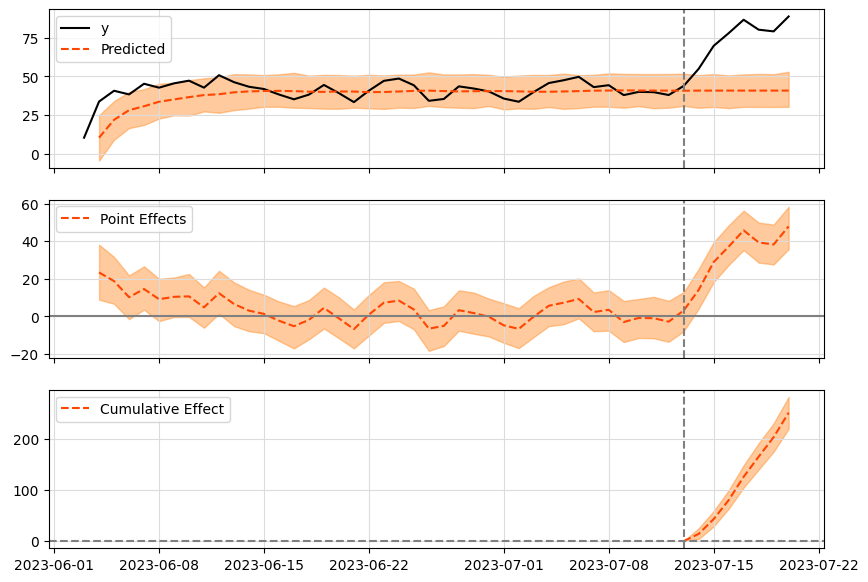

In [47]:
impact_5.plot()

In [48]:
print(impact_5.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    76.74              537.15
Prediction (s.d.)         40.84 (2.22)       285.86 (15.57)
95% CI                    [36.33, 45.05]     [254.32, 315.36]

Absolute effect (s.d.)    35.9 (2.22)        251.29 (15.57)
95% CI                    [31.68, 40.4]      [221.79, 282.83]

Relative effect (s.d.)    87.91% (5.45%)     87.91% (5.45%)
95% CI                    [77.59%, 98.94%]   [77.59%, 98.94%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [49]:
print(impact_5.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 76.74. By contrast, in the absence of an
intervention, we would have expected an average response of 40.84.
The 95% interval of this counterfactual prediction is [36.33, 45.05].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 35.9 with a 95% interval of
[31.68, 40.4]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 537.15.
By contrast, had the intervention not taken place, we would have expected
a sum of 285.86. The 95% interval of this prediction is [254.32, 315.36].


The above results are given in terms of absolute numbers. In relative
terms, the response variable

Мы наблюдаем значительный рост числа событий на пользователя: на 35.9 в абсолютных значениях и на 87.9% в относительных. Данное увеличение является статистически значимым. Вероятность того, что этот эффект произошел случайно равна 0.

# Выводы

- В течение недели проведения флэшмоба наблюдается значительное повышение следующих метрик: количество просмотров и лайков, количество событий на одного уникального пользователя и не большой рост CTR, но статистически значимый.
- Изменение метрик DAU и количество новых постов не считается статичестически значимым.
- Основная цель проведения флэшмоба выполнена - пользовательская активность выросла в период проведния флэшмоба.

Имел ли флэшмоб какие-то долгосрочные эффекты?
Я не вижу больших результатов долгосрочных от флешмоба , но и сказать что нет роста в активности пользователей не могу.